## Analysing the quantity of nodes with zero Betweenness Centrality for the real graphs tested

In this notebook some analysis is performed related to the quantity of nodes with zero betweenness centrality for the different graphs

The percentage of nodes with zero betweenness centrality is computed in addition to the part of these nodes that are identified beforehand by the model (trivial zeros)

Finally, the Kendall Tau values are computed again for the  last experiment without considering the nodes with a 0 Betweenness Centrality

### The zero BC nodes are analysed fot the graphs considered in the last experiment

In [3]:
import pickle

with open(f"outputs/obtained_results/real_performance_full_50_generated_train_graphs_30_seeds.pickle",'rb') as f:
    data = pickle.load(f)

for g in list(data.keys()):
    
    r = data[g]['LFR'][f'{list(data[g]["LFR"].keys())[0]}']['real']
    n = len(r)

    zeros = 0
    for v in r:
        if v == 0:
            zeros += 1

    print(f"Graph: {g}, Nodes: {n}, Found zeros (bet): {zeros} ({zeros/n*100} %), No zeros: {n-zeros} ({(n-zeros)/n*100} %)")

Graph: 1-wiki-Vote, Nodes: 7115, Found zeros (bet): 4711 (66.21222768798314 %), No zeros: 2404 (33.78777231201687 %)
Graph: 2-soc-Epinions, Nodes: 75879, Found zeros (bet): 50540 (66.60604383294456 %), No zeros: 25339 (33.39395616705544 %)
Graph: 3-email-EuAll, Nodes: 265214, Found zeros (bet): 258884 (97.61324816940282 %), No zeros: 6330 (2.386751830597178 %)


### Analysing how many of the zero nodes are identified  beforehand

In [8]:
# zeros beforehand 

from functions.utils import *

param = {
    "graphs": ['1-wiki-Vote','2-soc-Epinions','3-email-EuAll'],
    "sizes" : [10000,100000,300000],
    "copies": [1],
}
for i in range(len(param["graphs"])):

    g = param["graphs"][i]
    size = param["sizes"][i]
    data_test = f'{g}_{size}_size.pickle'

    #Load test data
    with open("./data_splits/test/"+data_test,"rb") as fopen:
        list_graph_test,list_n_seq_test,list_num_node_test,bc_mat_test,deg_mat_test = pickle.load(fopen)

    print(np.shape(bc_mat_test))
    s = np.shape(bc_mat_test)[0]
    for idx,val in enumerate(list_num_node_test):
        count = 0
        for j in list(bc_mat_test[:,idx]):
            if j == 0:
                count += 1
        print(f"nodes: {val}, realzeros: {(count-(s-val))}")
        #print(val, val - len(np.nonzero(bc_mat_test[:val,0].flatten())[0]))

        
    list_adj_test,list_adj_t_test = graph_to_adj_bet(list_graph_test,list_n_seq_test,list_num_node_test,size, showing_zeros=True)


(10000, 1)
nodes: 7115, realzeros: 4711
Processing 1 graphs...
Graph 0, Nodes: 7115, Beforehand zeros: 4711 (66.21222768798314 %)
(100000, 1)
nodes: 75879, realzeros: 50540
Processing 1 graphs...
Graph 0, Nodes: 75879, Beforehand zeros: 50540 (66.60604383294456 %)
(300000, 1)
nodes: 265214, realzeros: 258884
Processing 1 graphs...
Graph 0, Nodes: 265214, Beforehand zeros: 258884 (97.61324816940282 %)


### The possibility of computing the Kendall Tau without considering the zero BC nodes is added to the metrics function

In [10]:
from scipy.stats import kendalltau,pearsonr
import math

def nozeros(a,b):
    aout = []
    bout = []
    
    for idx,v in enumerate(b):
        if v != 0:
            aout.append(a[idx])
            bout.append(b[idx])
    
    return aout,bout

def metrics(pred_results,real_results, graph, positions=[],mlist={'equal':True,'in_top':True,'fullkendall':True,'nozeroskendall':True}):

    n = len(pred_results)
    assert n == len(real_results)

    nodes_sorted_pred = sorted(range(n),reverse=True,key=lambda k: pred_results[k])
    nodes_sorted_real = sorted(range(n),reverse=True,key=lambda k: real_results[k])
    
    m_dict = {'equal':{},'in_top':{}}
    
    if positions == []:
        if graph == '3-email-EuAll':
            percentages = range(1,11)
        else:
            percentages = range(1,101)
        values = []
        for p in percentages:
            values.append(int(p*n/100))
            for k in m_dict.keys():
                m_dict[k][p] = []
    
    else:

        values = positions
        for p in positions:
            for k in m_dict.keys():
                m_dict[k][p] = []

    #fullkendall
    if mlist['fullkendall']:
        m_dict['fullkendall'] = kendalltau(pred_results,real_results)

    # nozeros
    if mlist['nozeroskendall']:
        a,b = nozeros(pred_results,real_results)
        m_dict['nozeroskendall'] = kendalltau(a,b)

    # nodos igual posicion top
    if mlist['equal']:
        for idx, p in enumerate(values):
            print(f"Coincident: {idx}",end='\r')
            c = 0
            for j in range(p):
                if nodes_sorted_pred[j] == nodes_sorted_real[j]:
                    c += 1
            if len(positions) == 0:
                m_dict['equal'][percentages[idx]].append(round(c/p*100,4))
            else:
                m_dict['equal'][p].append(round(c/p*100,4))

    # nodos acertados top
    if mlist['in_top']:
        for idx, p in enumerate(values):
            print(f"In top: {idx}",end='\r')
            a = sum(1 for item in nodes_sorted_pred[:p] if item in nodes_sorted_real[:p])
            if len(positions) == 0:
                m_dict['in_top'][percentages[idx]].append(round(a/p*100,4))
            else:
                m_dict['in_top'][p].append(round(a/p*100,4))
    

    return m_dict

### Computing the metrics again for the 50 and 5 LFR and SF training graphs experiments

In [ ]:

with open(f"outputs/obtained_results/real_performance_full_50_generated_train_graphs_30_seeds.pickle",'rb') as f:
    data = pickle.load(f)

M = {}

for graph in ['3-email-EuAll','1-wiki-Vote','2-soc-Epinions']:
    M[graph] = {}

for graph in ['3-email-EuAll','1-wiki-Vote','2-soc-Epinions']:

    for seed in range(15):

        M[graph][seed] = {"SF": {}, "LFR": {}}

        for epoch in range(10):
            
            size = list(data[graph]['LFR'].keys())[0]
            print(f"Graph: {graph}, seed: {seed}, epoch: {epoch}")

            lfr_real = data[graph]['LFR'][f'{size}']['real']
            lfr_pred = data[graph]['LFR'][f'{size}']['1_copies']['pred'][f'{epoch}_epoch'][f"{seed}_seed"]['pred']
            sf_real = data[graph]['SF'][f'{size}']['real']
            sf_pred = data[graph]['SF'][f'{size}']['1_copies']['pred'][f'{epoch}_epoch'][f"{seed}_seed"]['pred']
            
            if epoch == 9:
                d = {'equal':True,'in_top':True,'fullkendall':True,'nozeroskendall':True}
            else:
                d = {'equal':False,'in_top':False,'fullkendall':True,'nozeroskendall':True}
            
            M[graph][seed]["SF"][f'{epoch}_epoch'] = metrics(sf_pred,sf_real,graph=graph,positions=range(2,101),mlist=d)
            
            M[graph][seed]["LFR"][f'{epoch}_epoch'] = metrics(lfr_pred,lfr_real,graph=graph,positions=range(2,101),mlist=d)

            with open(f"testingmetrics_50_LFR_SF_15_seeds_top100.pickle","wb") as fopen:
                pickle.dump(M,fopen)

In [ ]:

with open(f"outputs/obtained_results/real_performance_full_5_generated_train_graphs_15_seeds.pickle",'rb') as f:
    data = pickle.load(f)

M = {}

for graph in ['3-email-EuAll','1-wiki-Vote','2-soc-Epinions']:
    M[graph] = {}

for graph in ['3-email-EuAll','1-wiki-Vote','2-soc-Epinions']:

    for seed in range(15):

        M[graph][seed] = {"SF": {}, "LFR": {}}

        for epoch in range(10):
            
            size = list(data[graph]['LFR'].keys())[0]
            print(f"Graph: {graph}, seed: {seed}, epoch: {epoch}")

            lfr_real = data[graph]['LFR'][f'{size}']['real']
            lfr_pred = data[graph]['LFR'][f'{size}']['1_copies']['pred'][f'{epoch}_epoch'][f"{seed}_seed"]['pred']
            sf_real = data[graph]['SF'][f'{size}']['real']
            sf_pred = data[graph]['SF'][f'{size}']['1_copies']['pred'][f'{epoch}_epoch'][f"{seed}_seed"]['pred']
            
            if epoch == 9:
                d = {'equal':True,'in_top':True,'fullkendall':True,'nozeroskendall':True}
            else:
                d = {'equal':False,'in_top':False,'fullkendall':True,'nozeroskendall':True}
            
            M[graph][seed]["SF"][f'{epoch}_epoch'] = metrics(sf_pred,sf_real,graph=graph,positions=range(2,101),mlist=d)
            
            M[graph][seed]["LFR"][f'{epoch}_epoch'] = metrics(lfr_pred,lfr_real,graph=graph,positions=range(2,101),mlist=d)

            with open(f"testingmetrics_5_LFR_SF_15_seeds_top100.pickle","wb") as fopen:
                pickle.dump(M,fopen)

### The results obtained are plotted

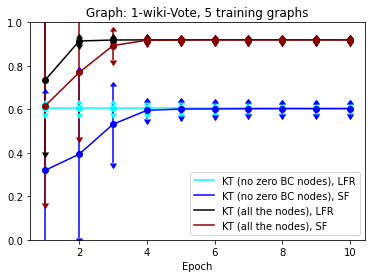

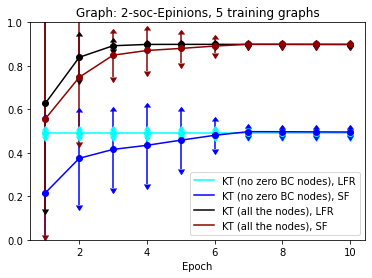

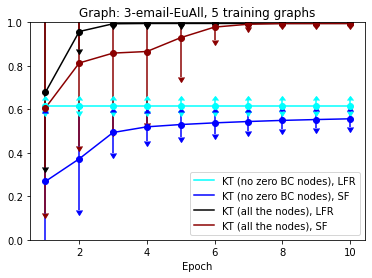

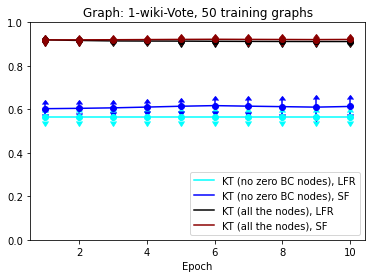

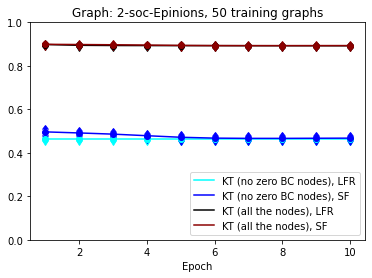

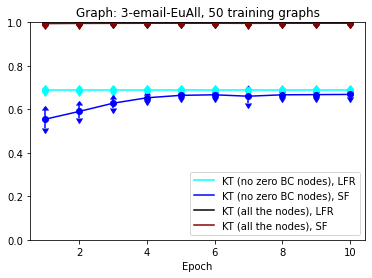

<Figure size 432x288 with 0 Axes>

In [15]:

import matplotlib.pyplot as plt
import pickle
import numpy as np

for training_graphs in [5,50]:
    
    graphs = ['1-wiki-Vote', '2-soc-Epinions', '3-email-EuAll']
    for graph in graphs:


        file = f"testingmetrics_{training_graphs}_LFR_SF_15_seeds_top100.pickle"

        with open(file,"rb") as fopen:
            M = pickle.load(fopen)


        metric = 'nozeroskendall'
        labelmetric = 'KT (no zero BC nodes)'
        gtype = 'LFR'
        color = 'cyan'
        seeds = range(15)

        xs = range(1,11)
        ys = []
        err = []
        for i in xs:
            j=10
            aux = []
            for seed in seeds:
                aux.append(M[graph][seed][gtype][f"{j-1}_epoch"][metric][0])
                
            ys.append(np.mean(np.array(aux)))
            err.append(np.std(np.array(aux)))
        plt.errorbar(xs,ys,err,c=color,uplims=True, lolims=True, fmt='o')
        plt.plot(xs,ys, c=color, label = f"{labelmetric}, {gtype}")


        metric = 'nozeroskendall'
        labelmetric = 'KT (no zero BC nodes)'
        gtype = 'SF'
        color = 'blue'
        seeds = range(15)

        xs = range(1,11)
        ys = []
        err = []
        for j in xs:
            aux = []
            for seed in seeds:
                aux.append(M[graph][seed][gtype][f"{j-1}_epoch"][metric][0])
                
            ys.append(np.mean(np.array(aux)))
            err.append(np.std(np.array(aux)))
        plt.errorbar(xs,ys,err,c=color,uplims=True, lolims=True, fmt='o')
        plt.plot(xs,ys, c=color, label = f"{labelmetric}, {gtype}")

        metric = 'fullkendall'
        labelmetric = 'KT (all the nodes)'
        gtype = 'LFR'
        color = 'black'
        seeds = range(15)

        xs = range(1,11)
        ys = []
        err = []
        for j in xs:
            aux = []
            for seed in seeds:
                aux.append(M[graph][seed][gtype][f"{j-1}_epoch"][metric][0])
                
            ys.append(np.mean(np.array(aux)))
            err.append(np.std(np.array(aux)))
        plt.errorbar(xs,ys,err,c=color,uplims=True, lolims=True, fmt='o')
        plt.plot(xs,ys, c=color, label = f"{labelmetric}, {gtype}")


        metric = 'fullkendall'
        labelmetric = 'KT (all the nodes)'
        gtype = 'SF'
        color = 'darkred'
        seeds = range(15)

        xs = range(1,11)
        ys = []
        err = []
        for j in xs:
            aux = []
            for seed in seeds:
                aux.append(M[graph][seed][gtype][f"{j-1}_epoch"][metric][0])
                
            ys.append(np.mean(np.array(aux)))
            err.append(np.std(np.array(aux)))
        plt.errorbar(xs,ys,err,c=color,uplims=True, lolims=True, fmt='o')
        plt.plot(xs,ys, c=color, label = f"{labelmetric}, {gtype}")

        plt.title(f'Graph: {graph}, {training_graphs} training graphs')
        plt.legend(loc=4)
        plt.ylim(0,1)
        plt.xlabel("Epoch")
        

        plt.show()
        plt.clf()